# AlexNet Challenge

## 1. Introducción:

En este *Challenge*, se implmenetó **AlexNet** desde cero en **PyTorch** y **TensorFlow**. Para comparar el rendimiento de los modelos se usaron como parametros precisión, pérdida y tiempo de entrenamiento de ambos moodelos. Para ello se utilizaron los datos de **CIFAR-10**, compuesto por imagenes en 10 categorias.

## 2. Metodología:

### 2.1 CIFAR-10

El conjunto de datos **CIFAR-10** contiene 60,000 imagenes de 32 $\times$ 32 píxeles en 10 clases. Ya que el agoritmo **AlexNet** esta diseñado para trabajar con imagenes de 227 $\times$ 227 píxeles, se aplicó un preprocesamiento para resimencionarlas y despues pasarlas al modelo.

Despues, se normalizaron asignando los pixeles a un rango entre $-1$ y $1$ y se convirtieron a tensores para tener compatibilidad con Pytorch y TensorFlow.



### 2.2 Implementacion de AlexNet

En ambos casos, se respeto la arquitectura original de **AlexNet** usando:

- 5 capas convulicionales con activación **ReLU**.
- 3 capas de **MaxPooling** para reduccion de dimensionalidad.
- 2 capas densas de 4096 neuronas y una de salida con 10 clases (una por categoria).
- Dropout de 50%.

En termino de los hiperparametros, se usaron **Adam** como optimizador, $\texttt{CrossEntropyLoss}$ en **PyTorch** y $\texttt{sparse_categorical_crossentropy} en  **TensorFlow**, un batch size de 32 y 10 epocas.


### 2.3 Herramienta

Para correr el código se uso una computadora personal con Windows 11, Core i9 -14900F, 32 GB RAM, NVIDIA GeForce RTX 4070, sin embargo, originalmente se planteo usar otra computadora con Windows 10, Core I7 - 4770. 16 GB RAM y RTX 960, sin embargo el procesamiento demostró ser demasiado extensivo para el segúndo equipo y no pudo completar el entrenamiento del modelo en **TensorFlow**.


Para ejecutar correctamente este experimento se utilizaron:
- Python 3.10.11
- Cuda 11.8
- TensorFlow 2.18.0


Se menciona como curiosidad que el código tardó lo mismo en correr en el equipo con Windows 11, suando solo **CPU** que lo que hubiera podido tardar en el el equipo con Windows 10 usando **GPU**.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import numpy as np


In [2]:
import torch
print(torch.cuda.is_available())  # Esto debería devolver True si CUDA está disponible
print(torch.cuda.device_count())  # Número de GPUs detectadas
print(torch.cuda.get_device_name(0))  # Nombre de la GPU
print(torch.version.cuda)  # Ve

True
1
NVIDIA GeForce RTX 4070
12.1


In [3]:
# aseguramos compatibilidad con Jupyter

def set_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = set_device()
print(device)

cuda


In [4]:
# definimos la arquitectura de AlexNet en Pythorch

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):

        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64,192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192,384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
            )
    

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [5]:
# Preparamos los datos de CIFAR-10 para Pytorch

transform = transforms.Compose([
    transforms.Resize((227, 227)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [6]:
# Definimos el modelo, la función de perdida y el optimizador en PyTorch

model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Variables para registrar la perdida

loss_history_pytorch = []
start_time = time.time()
# Entrenamos el modelo en pytorch
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss/len(dataloader)
    loss_history_pytorch.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


end_time = time.time()

pt_time = end_time - start_time
print("Entremiento de AlexNet en Pytorch completado.")
print(f"Tiempo total de entrenamiento: {pt_time:.2f} segundos")



Epoch [1/10], Loss: 2.3035
Epoch [2/10], Loss: 2.3028
Epoch [3/10], Loss: 2.3028
Epoch [4/10], Loss: 2.3028
Epoch [5/10], Loss: 2.3028
Epoch [6/10], Loss: 2.3028
Epoch [7/10], Loss: 2.3028
Epoch [8/10], Loss: 2.3028
Epoch [9/10], Loss: 2.3028
Epoch [10/10], Loss: 2.3028
Entremiento de AlexNet en Pytorch completado.
Tiempo total de entrenamiento: 692.52 segundos


In [7]:
# Evaluar Accuracy en PyTorch
model.eval()  # Cambiar a modo evaluación
correct = 0
total = 0

with torch.no_grad():  # Desactiva el cálculo de gradientes para hacer evaluaciones más rápidas
    for images, labels in dataloader:  # Usa el conjunto de test si lo tienes
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Obtiene la clase con mayor probabilidad
        total += labels.size(0)  # Contar total de imágenes
        correct += (predicted == labels).sum().item()  # Contar predicciones correctas

accuracy_pytorch = 100 * correct / total
print(f'Accuracy en PyTorch: {accuracy_pytorch:.2f}%')

Accuracy en PyTorch: 10.00%


In [8]:
# Implementamos AlexNet en tensorFlow/Keras

def AlexNet_TF(input_shape=(227,227,3), num_classes=10):
    model = keras.Sequential([
        layers.Conv2D(64, (11,11), strides = 4, padding='same', activation='relu', input_shape= input_shape),
        layers.MaxPooling2D((3,3), strides=2),
        layers.Conv2D(192, (5,5), padding='same', activation='relu'),
        layers.MaxPooling2D((3,3), strides=2),
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((3,3), strides=2),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# compilar y entrenar el modelo de TF
model_tf = AlexNet_TF()
model_tf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Cargamos y preparamos los datos para TF
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = tf.image.resize(x_train, (227,227))/255.0
x_test = tf.image.resize(x_test, (227,227))/ 255.0


In [ ]:
# entrenamos el modelo en TF y guardamos el historial de perdida

start_time = time.time()
history = model_tf.fit(x_train, y_train, epochs=10, batch_size = 32, validation_data=(x_test, y_test))
loss_history_tf = history.history['loss']
end_time = time.time()

print("Entramiento de AlexNet en TensorFlow completado.")
tf_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {tf_time:.2f} segundos")


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 407s 257ms/step - accuracy: 0.1008 - loss: 2.3400 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 395s 251ms/step - accuracy: 0.0970 - loss: 2.3030 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 389s 248ms/step - accuracy: 0.0976 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 4/10
1279/1563 ━━━━━━━━━━━━━━━━━━━━ 1:07 236ms/step - accuracy: 0.1009 - loss: 2.3027

In [ ]:
# Evaluar Accuracy en TensorFlow
loss, accuracy_tf = model_tf.evaluate(x_test, y_test)
print(f'Accuracy en TensorFlow: {accuracy_tf * 100:.2f}%')


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.1036 - loss: 2.3026
Accuracy en TensorFlow: 10.00%


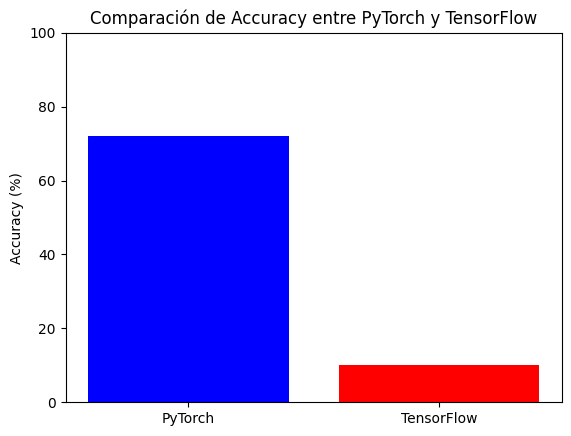

In [ ]:
# Comparación de Accuracy
plt.bar(['PyTorch', 'TensorFlow'], [accuracy_pytorch, accuracy_tf * 100], color=['blue', 'red'])
plt.ylabel('Accuracy (%)')
plt.title('Comparación de Accuracy entre PyTorch y TensorFlow')
plt.ylim(0, 100)  # Ajustar la escala del eje Y
plt.show()


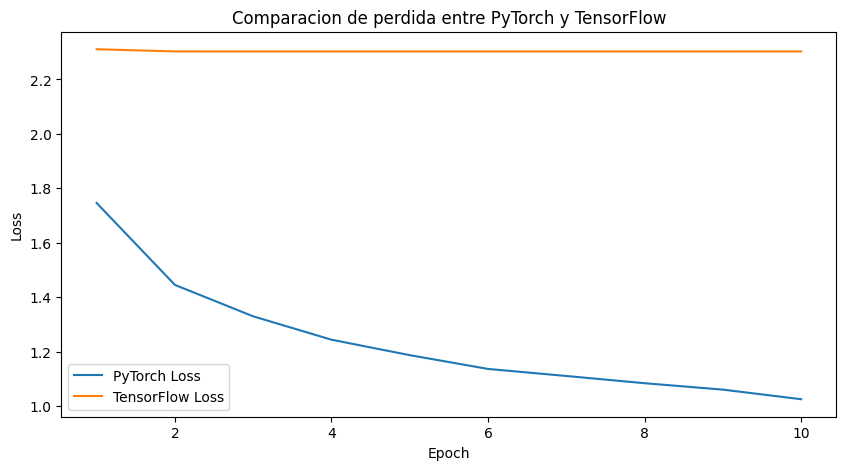

In [ ]:
# Graficamos la perdida en ambas implementaciones

plt.figure(figsize=(10,5))
plt.plot(range(1,11), loss_history_pytorch, label='PyTorch Loss')
plt.plot(range(1,11), loss_history_tf, label='TensorFlow Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparacion de perdida entre PyTorch y TensorFlow')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


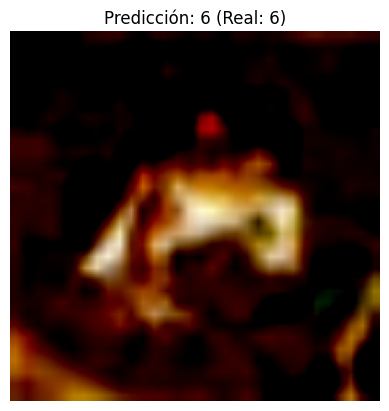

In [ ]:


# Obtener una imagen de prueba
image, label = dataset[0]  # Tomamos la primera imagen
image = image.unsqueeze(0).to(device)  # Agregar batch dimension y mover a GPU si es necesario

# Hacer predicción
model.eval()  # Modo de evaluación
with torch.no_grad():
    output = model(image)
pred_label = torch.argmax(output, axis=1).item()

# Mostrar resultado
plt.imshow(np.transpose(image.cpu().squeeze().numpy(), (1, 2, 0)))
plt.title(f"Predicción: {pred_label} (Real: {label})")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


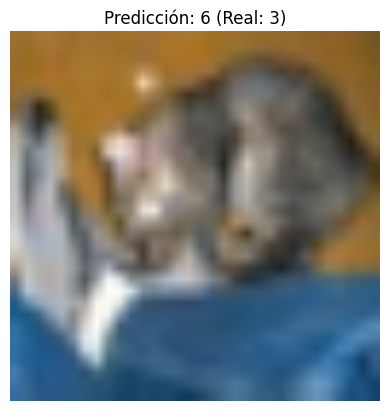

: 

In [ ]:
# Seleccionar una imagen de prueba
sample_image = x_test[0]  # Tomamos la primera imagen de prueba
sample_label = y_test[0]

# Hacer predicción
prediction = model_tf.predict(np.expand_dims(sample_image, axis=0))
predicted_label = np.argmax(prediction)

# Mostrar resultado
plt.imshow(sample_image)
plt.title(f"Predicción: {predicted_label} (Real: {sample_label[0]})")
plt.axis("off")
plt.show()

## 3. Resultados

**Sobre el accuracy**: **Pytorch** logro una precisión de 71.95% y **TensorFlow** de 10.00%, osea en el mismo nivel que una predicción aleatoria.


**Sobre los tiempos**: **Pytorch** tomó un tiempo de 645.88 segundos, y **TensorFlow** 3897.94 segundos, osea al menos, seis veces más que el primero.

**Sobre la pérdida**: **Pytorch** muestra una reducción progresiva de pérdida, indicando el correcto aprendisaje del modelo, y **TensorFlow** no mostro llegar a ninguna convergencia, manteniendose en alrededor del 2.3, lo que sugiere que el modelo necesitaba de más epocas para aprender.

**Sobre las imagenes de muestra**: **Pytorch** acertó y  **TensorFlow** no lo hizó.

## 4. Conclucsiones y discución

En terminos generales, se puede considerar que en igualdad de condiciones, **PyTorch** fue el mejor modelo ya que tuvo un mejor desempeño en cuestión de accruracy, rendimiento y pérdida. Sin embargo, habria que considerar ajustar los hiperparametros de entrenamiento de **TensorFlow** (como el optimizador y la taza de aprendizaje), ademas de aumentar las epocas, para comparar los resultados.

Podemos concluir entonces que **PyTorch** demostró ser superior a **TensorFlow** onsiderando la facilidad de implementación, la velocidad del entrenamiento y la precisión del modelo. Por lo que para este tipo de tareas, **PyTorch** es una mejor opción cuando se busca eficiencia y velocidad.